In [1]:
import anndata as ad

In [2]:
adata  = ad.read_h5ad("D:/wochong_2023/3D Registration/h5ad_back/10dpa2_align_merged.h5ad")

In [3]:
import numpy as np
import pandas as pd
import scipy.linalg as sl
import matplotlib.pyplot as plt
from skimage import io as skio

def polyfix(x, y, xfix, yfix, n=3):
    """
    This code is copy from https://github.com/jbae11/polyfix.py with minor changes 
    Fits polynomial p with degree n to data with constrains
    
    param (x,y): 2D coordinates of all training data.
    param n: degree of polynomial.
    param (xfix,yfix): 2D coordinates of all constrain points.
    """
    nfit = len(x)
    if len(y) != nfit:
        raise ValueError('x and y must have the same size')
    nfix = len(xfix)
    if len(yfix) != nfix:
        raise ValueError('xfit adn yfit must have the same size')
    x = np.vstack(x)
    y = np.vstack(y)
    if nfix > 1 :
        xfix = np.vstack(xfix)
        yfix = np.vstack(yfix)

    nspec = nfix
    specval = yfix
    # first find A and pc such that A*pc = specval
    A = np.zeros((nspec, n+1))
    # specified y values
    for i in range(n+1):
        A[:nfix, i] = np.hstack(np.ones((nfix, 1)) * xfix**(n+1-(i+1)))

    if nfix > 0:
        lastcol = n+1
        nmin = nspec - 1
    else:
        lastcol = n
        nmin = nspec

    if n < nmin:
        raise ValueError('Polynomial degree too low, cannot match all constraints')
    # find unique polynomial of degree nmin that fits the constraints
    firstcol = n-nmin
    pc0 = np.linalg.solve(A[:, firstcol:lastcol], specval)
    pc = np.zeros((n+1, 1))
    pc[firstcol:lastcol] = pc0
    
    X = np.zeros((nfit, n+1))
    for i in range(n+1):
        X[:, i] = (np.ones((nfit, 1)) * x**(n+1-(i+1))).flatten()

    yfit = y - np.polyval(pc, x)

    B = sl.null_space(A)
    #z = np.linalg.lstsq(X @ B, yfit,rcond=None)[0]
    z = np.linalg.lstsq(X @ B, yfit)[0]
    if len(z) == 0:
        z = z[0]
        p0 = B*z
    else:
        p0 = B@z
    p = np.transpose(p0) + np.transpose(pc)
    return p

def getMidline(f1, x_max, x_min, y_max, y_min,w):
    xvals = np.array(range(0,w))
    yvals = np.polyval(f1[0], xvals)
    line_df = pd.DataFrame(columns=['x','y'])
    line_df['x'] = xvals
    # half adjust
    line_df['x'] = (line_df['x']+0.5).astype('int')
    line_df['y'] = yvals
    # half adjust  
    line_df['y'] = (line_df['y']+0.5).astype('int')
    line_df = line_df[line_df['y']<y_max]
    line_df = line_df[line_df['x']<x_max]
    line_df = line_df[line_df['y']>y_min]
    line_df = line_df[line_df['x']>x_min]
    return line_df

def drawImageWithLine(x,y,line_df,w,h,prefix='draw01'):
    line = np.zeros((h,w))
    line[y,x]=200
    line[line_df['y'],line_df['x']]=255
    skio.imsave(f'{prefix}.png',line)

def scatterWithLine(x,y,line_df):
    plt.figure()
    plt.scatter(x,y,s=2)
    plt.plot(line_df['x'],line_df['y'],c='r')
    plt.gca().set_aspect('equal')
    #plt.show()

In [4]:
adata

AnnData object with n_obs × n_vars = 225385 × 19574
    obs: 'x', 'y', 'nSpots', 'nGenes', 'nUMI', 'sample', 'slice', 'cell_id', 'seurat_cluster_res0.8', 'new_x', 'new_y', 'z', 'seurat_cluster_res0.8_nofilter', 'seurat_cluster_res1.6', 'seurat_cluster_res1.6_nofilter'
    obsm: 'spatial', 'spatial_3d', 'spatial_3d_all17'

In [5]:
adata.obs['new_z']  = adata.obs['z'] 
adata.obsm['spatial'] = adata.obs[ ['new_x','new_y','new_z'] ].to_numpy()
adata.obsm['spatial']

array([[4504.98014798, 1537.38002575,  780.        ],
       [4658.09057716, 2183.85150184,  780.        ],
       [4934.05057174, 1503.53607418,  780.        ],
       ...,
       [4152.13058727, 1290.76371267,  400.        ],
       [2867.15496118, 1427.44542456,  400.        ],
       [3873.35221   , 1663.83725283,  400.        ]])

In [6]:
fz583 = 'SMESG000035834.1'
slit1 = 'SMESG000068721.1'
wnt11_1 = 'SMESG000005930.1'

used_adata = adata[:,[fz583,slit1,wnt11_1]].copy()
used_adata.var

""
genename
SMESG000035834.1
SMESG000068721.1
SMESG000005930.1


In [7]:
#used_adata.obs['fz583'] 
import numpy as np
xxx = used_adata[:,fz583].X.todense().reshape(-1).tolist()
used_adata.obs['fz583'] = xxx[0]  
xxx = used_adata[:,slit1].X.todense().reshape(-1).tolist()
used_adata.obs['slit1'] = xxx[0]  
xxx = used_adata[:,wnt11_1].X.todense().reshape(-1).tolist()
used_adata.obs['wnt11_1'] = xxx[0]  

In [8]:
used_adata = used_adata[ ( (used_adata.obs['fz583'] >0)|(used_adata.obs['slit1'] >0)|(used_adata.obs['wnt11_1'] >0)) ]
used_adata

View of AnnData object with n_obs × n_vars = 697 × 3
    obs: 'x', 'y', 'nSpots', 'nGenes', 'nUMI', 'sample', 'slice', 'cell_id', 'seurat_cluster_res0.8', 'new_x', 'new_y', 'z', 'seurat_cluster_res0.8_nofilter', 'seurat_cluster_res1.6', 'seurat_cluster_res1.6_nofilter', 'new_z', 'fz583', 'slit1', 'wnt11_1'
    obsm: 'spatial', 'spatial_3d', 'spatial_3d_all17'

In [9]:
fz583_data = used_adata[used_adata.obs['fz583'] >0].copy()
slit1_data = used_adata[used_adata.obs['slit1'] >0].copy()
wnt11_1_data = used_adata[used_adata.obs['wnt11_1'] >0].copy()

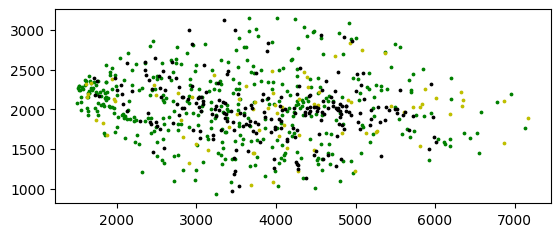

In [10]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(fz583_data.obs['new_x'],fz583_data.obs['new_y'],c='g',s=3)
plt.scatter(wnt11_1_data.obs['new_x'],wnt11_1_data.obs['new_y'],c='y',s=3)
plt.scatter(slit1_data.obs['new_x'],slit1_data.obs['new_y'],c='black',s=3)
plt.gca().set_aspect('equal')
#plt.plot(line_df['x'],line_df['y'])
plt.show()

In [11]:
def drawImage(x0,y0,x,y,w,h,prefix='draw01'):
    x0 = x0.to_numpy().astype(int)
    y0 = y0.to_numpy().astype(int)
    x = x.to_numpy().astype(int)
    y = y.to_numpy().astype(int)

    line = np.zeros((h,w))
    line[y0,x0]=150
    line[y,x]=255
    skio.imsave(f'{prefix}.png',line)

# draw image to find the fixed points:
drawImage(adata.obs['new_x'],adata.obs['new_y'],used_adata.obs['new_x'],used_adata.obs['new_y'],8000,4000,'10dpa2_body')

C:\Users\guolidong\AppData\Local\Temp\ipykernel_13104\1304777353.py:10: UserWarning: 10dpa2_body.png is a low contrast image
  skio.imsave(f'{prefix}.png',line)
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


In [12]:
#fixx = [2300,3350,8000,8700]
#fixy = [2500,2850,2800,2600]
fixx = [1525 ,7200]
fixy = [2225,1850]
f1 = polyfix(used_adata.obs['new_x'].to_list(),used_adata.obs['new_y'].to_list(),fixx,fixy,n=4)
#f1 = polyfix(slit1_data.obs['new_x'].to_list(),slit1_data.obs['new_y'].to_list(),fixx,fixy,n=4)
midline = getMidline(f1, 7500, 1500, 3500, 500,8000)

C:\Users\guolidong\AppData\Local\Temp\ipykernel_13104\727444766.py:59: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  z = np.linalg.lstsq(X @ B, yfit)[0]


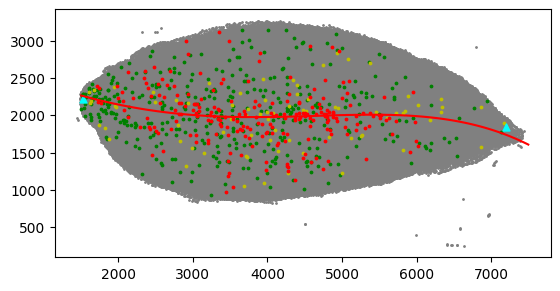

In [13]:
scatterWithLine(slit1_data.obs['new_x'].to_list(),slit1_data.obs['new_y'].to_list(),midline)
plt.scatter(adata.obs['new_x'],adata.obs['new_y'],c='gray',s=1)
plt.scatter(fz583_data.obs['new_x'],fz583_data.obs['new_y'],c='g',s=3)
plt.scatter(wnt11_1_data.obs['new_x'],wnt11_1_data.obs['new_y'],c='y',s=3)
plt.scatter(slit1_data.obs['new_x'],slit1_data.obs['new_y'],c='r',s=3)
plt.scatter(fixx,fixy,s=25,c='cyan',marker='^')
plt.show()

In [14]:
f1

array([[-1.40596268e-12,  9.81619394e-09,  4.52222132e-05,
        -4.61221827e-01,  2.83054135e+03]])

In [16]:
def update_np(the_raw_pos, the_midline, f1):
    def Yinline(f1,xvals):
        return np.polyval(f1[0], xvals)
    the_result = pd.DataFrame()
    the_result['raw_x'] = the_raw_pos[:,0]
    the_result['raw_y'] = the_raw_pos[:,1]
    the_result['raw_yline'] =  Yinline(f1,the_raw_pos[:,0])

    def Ytag(item):
        if item['raw_y']>item['raw_yline']:
            return 1;
        elif item['raw_y']<item['raw_yline']:
            return -1;
        else:
            return 1
    the_result['ytag'] = the_result.apply(lambda row: Ytag(row),axis=1)
    from scipy.spatial import KDTree
    from scipy.spatial import distance
    the_line_new_points = the_midline.to_numpy()
    length = np.zeros(len(the_line_new_points))
    for i in range(1,len(the_line_new_points)):
        length[i] = distance.euclidean(the_line_new_points[i,:],the_line_new_points[i-1,:])
    length = np.cumsum(length)
    the_kdtree = KDTree(np.array(the_line_new_points))

    darray, iarray = the_kdtree.query(the_raw_pos)

    the_result['ny'] = darray
    the_result['ny'] = the_result['ny']*the_result['ytag']
    the_result['nx'] = length[np.array(iarray).astype(int)]
    return the_result

def update_adata(the_data, the_midline, f1):
    the_raw_pos = the_data.obs[['new_x','new_y']].to_numpy()
    the_result = update_np(the_raw_pos, the_midline, f1)
    the_data.obs['AP_adj_x'] = the_result['nx'].to_numpy()
    the_data.obs['AP_adj_y'] = the_result['ny'].to_numpy()
    return the_data

In [17]:
adata = update_adata(adata,midline,f1)
adata

AnnData object with n_obs × n_vars = 225385 × 19574
    obs: 'x', 'y', 'nSpots', 'nGenes', 'nUMI', 'sample', 'slice', 'cell_id', 'seurat_cluster_res0.8', 'new_x', 'new_y', 'z', 'seurat_cluster_res0.8_nofilter', 'seurat_cluster_res1.6', 'seurat_cluster_res1.6_nofilter', 'new_z', 'AP_adj_x', 'AP_adj_y'
    obsm: 'spatial', 'spatial_3d', 'spatial_3d_all17'

In [18]:
fz583_data = update_adata(fz583_data,midline,f1)
slit1_data = update_adata(slit1_data,midline,f1) 
wnt11_1_data= update_adata(wnt11_1_data,midline,f1) 

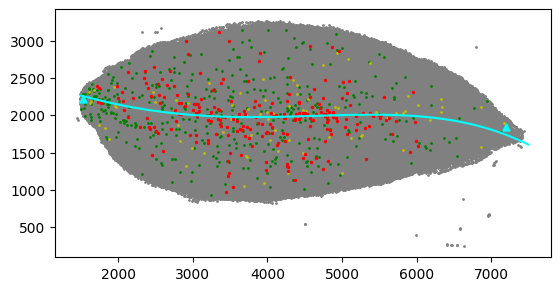

In [19]:
plt.figure()
plt.scatter(adata.obs['new_x'],adata.obs['new_y'],c='gray',s=1)
plt.scatter(fz583_data.obs['new_x'],fz583_data.obs['new_y'],c='green',s=1)
plt.scatter(wnt11_1_data.obs['new_x'],wnt11_1_data.obs['new_y'],c='y',s=1)
plt.scatter(slit1_data.obs['new_x'],slit1_data.obs['new_y'],c='r',s=2)
plt.gca().set_aspect('equal')
plt.scatter(fixx,fixy,s=25,c='cyan' ,marker='^')
plt.plot(midline['x'],midline['y'],c='cyan')
plt.show()

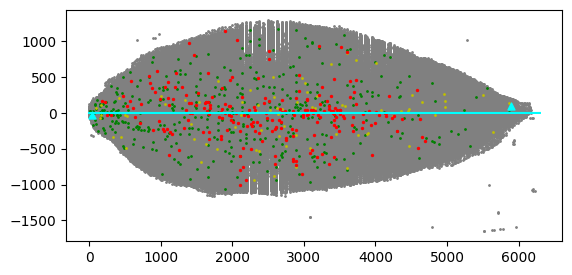

In [20]:
fixed_ret = update_np(np.array([[1525,2225],[7200, 1850]]), midline, f1)
mid_ret = update_np(midline.to_numpy(),midline, f1)
plt.figure()
plt.scatter(adata.obs['AP_adj_x'],adata.obs['AP_adj_y'],c='gray',s=1)
plt.scatter(fz583_data.obs['AP_adj_x'],fz583_data.obs['AP_adj_y'],c='green',s=1)
plt.scatter(wnt11_1_data.obs['AP_adj_x'],wnt11_1_data.obs['AP_adj_y'],c='y',s=1)
plt.scatter(slit1_data.obs['AP_adj_x'],slit1_data.obs['AP_adj_y'],c='r',s=2)
plt.gca().set_aspect('equal')
plt.scatter(fixed_ret['nx'],fixed_ret['ny'],s=25,c='cyan' ,marker='^')
plt.plot(mid_ret['nx'],mid_ret['ny'],c='cyan')
plt.show()

In [21]:
adata.obsm['spatial_APadj'] = adata.obs[['AP_adj_x','AP_adj_y','new_z']].to_numpy()

In [22]:
adata.write('10dpa2.apadj.h5ad',compression='gzip')